In [6]:
# === CNN‑LSTM 90‑Day Forecast Pipeline ===
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)
import matplotlib.pyplot as plt

In [7]:
# reproducibility
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [8]:
paths = [
    "C:/Users/mahar/Downloads/Capstone for Models/cpz_station_timeseries_2021_yearly_15min.parquet",
    "C:/Users/mahar/Downloads/Capstone for Models/cpz_station_timeseries_2022_yearly_15min.parquet",
    "C:/Users/mahar/Downloads/Capstone for Models/cpz_station_timeseries_2023_yearly_15min.parquet",
    "C:/Users/mahar/Downloads/Capstone for Models/cpz_station_timeseries_2024_yearly_15min.parquet"
]


In [9]:
dfs = []
for p in paths:
    dfp = pd.read_parquet(p, engine="pyarrow") \
            .rename(columns={
                "time_bucket": "ds",
                "start_station_id": "station_id",
                "booking_count": "y"
            })
    dfp["ds"] = pd.to_datetime(dfp["ds"])
    dfs.append(dfp)
rides_df = pd.concat(dfs, ignore_index=True)

In [10]:
# filter to one station
station_id = "4818.03"
rides_df = rides_df[rides_df["station_id"].astype(str) == station_id].copy()

# aggregate daily
rides_df["ds"] = rides_df["ds"].dt.floor("D")
rides_daily = rides_df.groupby("ds", as_index=False)["y"].sum()


In [11]:
# === 2. Load & Merge Weather + Urban Features ===
# weather
weather_df = pd.read_csv(
    "C:/Users/mahar/Downloads/Capstone for Models/final_weather_dataset (1) (1).csv",
    parse_dates=["DATE"]
).rename(columns={"DATE":"ds"})

# static urban features
urban_df = pd.read_csv(
    "C:/Users/mahar/Downloads/Final_Urban_Feaatures_Merged_csv.csv",
    header=1
)
urban_df["station_id"] = urban_df["station_id"].astype(str)
uf = (urban_df.set_index("station_id")
            .loc[station_id]
            .drop("station_id", errors="ignore")
            .to_dict())

# merge
df = (rides_daily
      .merge(weather_df, on="ds", how="left")
      .assign(**uf)
      .sort_values("ds")
      .reset_index(drop=True))

# one‑hot weather category
if "WEATHER_CATEGORY" in df.columns:
    df = pd.get_dummies(df,
                        columns=["WEATHER_CATEGORY"],
                        prefix="WEATHER_CATEGORY")

# fill gaps
df.ffill(inplace=True)
df.bfill(inplace=True)
df.fillna(0, inplace=True)


In [12]:
# === 3. Add Date Features & Prepare Arrays ===
# day‑of‑week + month + day‑of‑year seasonal features
df["dow"]     = df["ds"].dt.dayofweek
df["mth"]     = df["ds"].dt.month
df["doy"]     = df["ds"].dt.dayofyear
df["dow_sin"] = np.sin(2*np.pi*df["dow"]/7)
df["dow_cos"] = np.cos(2*np.pi*df["dow"]/7)
df["mth_sin"] = np.sin(2*np.pi*(df["mth"]-1)/12)
df["mth_cos"] = np.cos(2*np.pi*(df["mth"]-1)/12)
df["doy_sin"] = np.sin(2*np.pi*df["doy"]/365)
df["doy_cos"] = np.cos(2*np.pi*df["doy"]/365)
df.drop(columns=["dow","mth","doy"], inplace=True)

# extract target & covariates
df_daily = df.copy()
dates      = df_daily["ds"].values
y_raw      = df_daily["y"].values.reshape(-1,1)
cov_raw    = df_daily.drop(columns=["ds","y"], errors="ignore").values

# scale
y_scaler   = StandardScaler();    target     = y_scaler.fit_transform(y_raw)
cov_scaler = StandardScaler();    covariates = cov_scaler.fit_transform(cov_raw)

# train/val/test split
n         = len(target)
train_end = int(0.70 * n)
val_end   = int(0.85 * n)

# prepare slices
train_y, val_y, test_y = (target[:train_end],
                          target[train_end:val_end],
                          target[val_end:])
train_c, val_c, test_c = (covariates[:train_end],
                          covariates[train_end:val_end],
                          covariates[val_end:])


In [13]:
# === 4. Sequence Dataset ===
class SeqDataset(Dataset):
    def __init__(self, y, c, ctx):
        self.y, self.c, self.ctx = y, c, ctx
    def __len__(self):
        return len(self.y) - self.ctx
    def __getitem__(self, i):
        seq_y = self.y[i:i+self.ctx]
        seq_c = self.c[i:i+self.ctx]
        x     = np.concatenate([seq_y, seq_c], axis=1)
        y_t   = self.y[i+self.ctx, 0]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y_t, dtype=torch.float32)

context    = 30
batch_size = 32

train_dl = DataLoader(SeqDataset(train_y, train_c, context),
                      batch_size=batch_size, shuffle=True)
val_dl   = DataLoader(SeqDataset(val_y,   val_c,   context),
                      batch_size=batch_size)
test_ds  = SeqDataset(test_y, test_c, context)


In [36]:
# === 5. CNN‑LSTM Model ===
class CNNTimeseries(nn.Module):
    def __init__(self, in_feats, conv_ch=32, lstm_h=64, lstm_layers=1):
        super().__init__()
        self.conv = nn.Conv1d(in_channels=in_feats,
                              out_channels=conv_ch,
                              kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(conv_ch, lstm_h,
                            num_layers=lstm_layers,
                            batch_first=True)
        self.fc   = nn.Linear(lstm_h, 1)

    def forward(self, x):
        # x: [B, ctx, feat]
        x = x.transpose(1,2)         # → [B, feat, ctx]
        x = self.relu(self.conv(x))  # → [B, conv_ch, ctx]
        x = x.transpose(1,2)         # → [B, ctx, conv_ch]
        h, _ = self.lstm(x)          # → [B, ctx, lstm_h]
        return self.fc(h[:,-1,:]).squeeze(-1)

# instantiate
in_feats = 1 + covariates.shape[1]
model    = CNNTimeseries(in_feats).to(device)
opt      = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn  = nn.MSELoss()


In [37]:
# === 6. Training Loop ===
train_losses_cnn = []
val_losses_cnn   = []
epochs = 20
for ep in range(1, epochs+1):
    model.train()
    tr_losses = []
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        loss = loss_fn(model(xb), yb)
        loss.backward()
        opt.step()
        tr_losses.append(loss.item())
    # validation
    model.eval()
    vl_losses = []
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            vl_losses.append(loss_fn(model(xb), yb).item())
    print(f"Epoch {ep:02d} train_loss: {np.mean(tr_losses):.4f} — val_loss: {np.mean(vl_losses):.4f}")
train_losses_cnn.append(np.mean(tr_losses))
val_losses_cnn.append(  np.mean(vl_losses))



Epoch 01 train_loss: 0.7778 — val_loss: 0.4911
Epoch 02 train_loss: 0.5900 — val_loss: 0.4942
Epoch 03 train_loss: 0.5680 — val_loss: 0.4871
Epoch 04 train_loss: 0.5550 — val_loss: 0.4755
Epoch 05 train_loss: 0.5289 — val_loss: 0.4816
Epoch 06 train_loss: 0.5271 — val_loss: 0.4695
Epoch 07 train_loss: 0.5365 — val_loss: 0.4803
Epoch 08 train_loss: 0.5116 — val_loss: 0.4612
Epoch 09 train_loss: 0.5174 — val_loss: 0.4827
Epoch 10 train_loss: 0.5130 — val_loss: 0.4814
Epoch 11 train_loss: 0.4974 — val_loss: 0.4720
Epoch 12 train_loss: 0.5029 — val_loss: 0.4683
Epoch 13 train_loss: 0.4921 — val_loss: 0.5226
Epoch 14 train_loss: 0.4882 — val_loss: 0.4863
Epoch 15 train_loss: 0.4831 — val_loss: 0.4741
Epoch 16 train_loss: 0.4726 — val_loss: 0.5318
Epoch 17 train_loss: 0.4741 — val_loss: 0.5250
Epoch 18 train_loss: 0.4750 — val_loss: 0.5222
Epoch 19 train_loss: 0.4755 — val_loss: 0.5014
Epoch 20 train_loss: 0.4749 — val_loss: 0.4772


In [39]:
# === 7. Test‐Set Evaluation ===
model.eval()
preds, trues = [], []
with torch.no_grad():
    for i in range(len(test_ds)):
        xb, yb = test_ds[i]
        p = model(xb.unsqueeze(0).to(device)).cpu().item()
        preds.append(p); trues.append(yb.item())

true_test = y_scaler.inverse_transform(np.array(trues).reshape(-1,1)).ravel()
pred_test = y_scaler.inverse_transform(np.array(preds).reshape(-1,1)).ravel()

mae  = mean_absolute_error(true_test, pred_test)
mse  = mean_squared_error(true_test, pred_test)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(true_test, pred_test)*100
print("\n Test Metrics:")
print(f" MAE  = {mae:.3f}")
print(f" MSE  = {mse:.3f}")
print(f" RMSE = {rmse:.3f}")
print(f" MAPE = {mape:.2f}%")



 Test Metrics:
 MAE  = 5.614
 MSE  = 50.464
 RMSE = 7.104
 MAPE = 30.16%


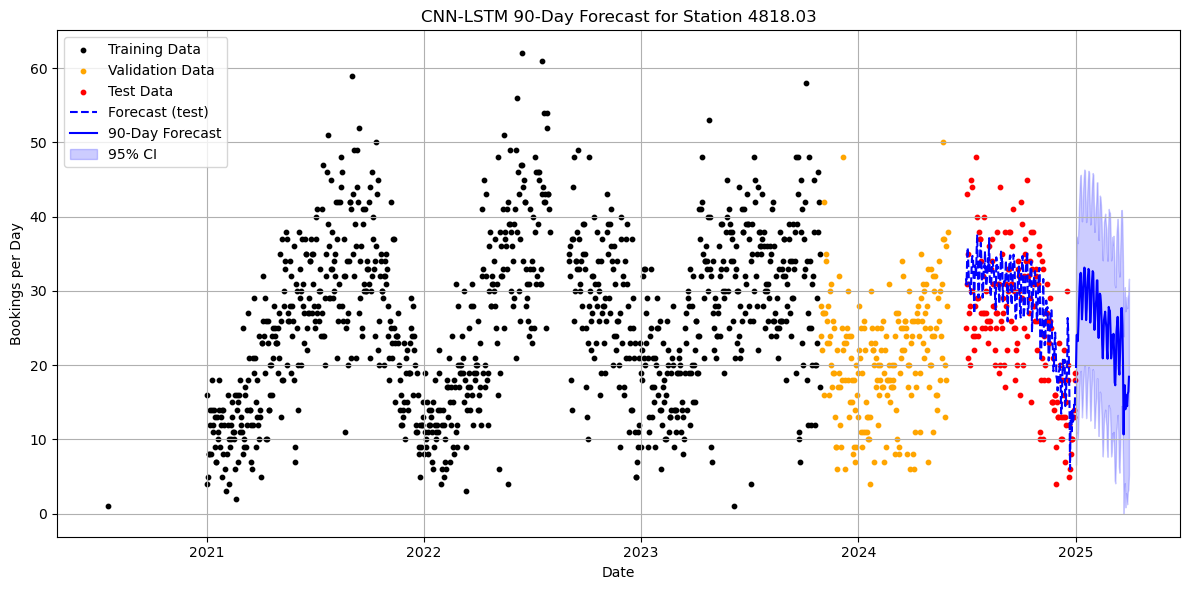

In [40]:
sigma = np.std(true_test - pred_test)


# === 8. 90‑Day Roll‑Forward Forecast & Plot ===
look_ahead = 90

# seed context
ctx_seq     = np.concatenate([target[-context:].reshape(-1,1),
                              covariates[-context:]], axis=1)
future_cov  = covariates[-look_ahead:]
future_preds = []

model.eval()
with torch.no_grad():
    for t in range(look_ahead):
        inp = torch.tensor(ctx_seq[-context:], dtype=torch.float32)\
                   .unsqueeze(0).to(device)
        o   = model(inp).cpu().item()
        future_preds.append(o)
        ctx_seq = np.vstack([ctx_seq, np.concatenate([[o], future_cov[t]])])

future_vals = y_scaler.inverse_transform(
    np.array(future_preds).reshape(-1,1)
).ravel()
future_vals = np.maximum(future_vals, 0)

# build date arrays
dates_all    = pd.to_datetime(df_daily["ds"])
train_dates  = dates_all.iloc[:train_end]
val_dates    = dates_all.iloc[train_end:val_end]
test_dates   = dates_all.iloc[val_end+context : val_end+context+len(pred_test)]
future_dates = pd.date_range(dates_all.iloc[-1] + pd.Timedelta(days=1),
                             periods=look_ahead)

# raw values
train_vals = y_scaler.inverse_transform(target[:train_end]).ravel()
val_vals   = y_scaler.inverse_transform(target[train_end:val_end]).ravel()

# plot
plt.figure(figsize=(12,6))
plt.scatter(train_dates, train_vals, s=10, c="black",  label="Training Data")
plt.scatter(val_dates,   val_vals,   s=10, c="orange", label="Validation Data")
plt.scatter(test_dates,  true_test,  s=10, c="red",    label="Test Data")
# forecast on test (dashed)
plt.plot(test_dates, pred_test, "--", c="blue", label="Forecast (test)")
# 90‑day forecast (solid)
plt.plot(future_dates, future_vals, "-", c="blue", label=f"{look_ahead}-Day Forecast")
# CI shading
ci_lo = np.maximum(future_vals - 1.96*sigma, 0)
ci_hi = future_vals + 1.96*sigma
plt.fill_between(future_dates, ci_lo, ci_hi,
                 color="blue", alpha=0.2, label="95% CI")

plt.title(f"CNN‑LSTM 90‑Day Forecast for Station {station_id}")
plt.xlabel("Date"); plt.ylabel("Bookings per Day")
plt.legend(loc="upper left"); plt.grid(True); plt.tight_layout()
plt.show()

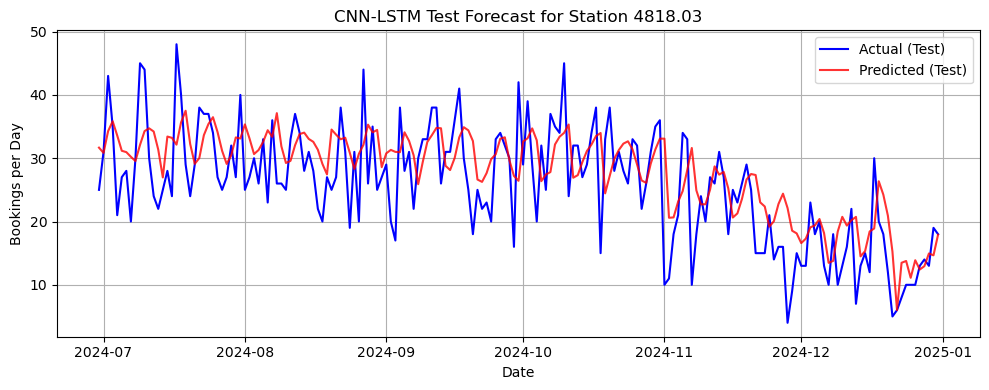

In [41]:
# 9. Plot Actual vs Predicted
test_dates = dates[val_end + context:]
plt.figure(figsize=(10,4))
plt.plot(test_dates, true_test, label="Actual (Test)", color="blue")
plt.plot(test_dates, pred_test, label="Predicted (Test)", color="red", alpha=0.8)
plt.title(f"CNN-LSTM Test Forecast for Station {station_id}")
plt.xlabel("Date"); plt.ylabel("Bookings per Day")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()